# Richards model prediction of Covid-19 for Spain

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  # plots
import pymc3 as pm
import arviz as az

# Source: https://es.wikipedia.org/wiki/ISO_3166-2:ES
map_code_name = {'AN': 'Andalucia', 'AR': 'Aragon', 'AS': 'Principado_de_Asturias',
                 'CN': 'Canarias', 'CB': 'Cantabria', 'CM': 'Castilla_La_Mancha',
                 'CL': 'Castilla_y_Leon', 'CT': 'Catalunya', 'EX': 'Extremadura',
                 'GA': 'Galicia', 'IB': 'Illes_Balears', 'RI': 'La_Rioja',
                 'MD': 'Comunidad_de_Madrid', 'MC': 'Region_de_Murcia', 
                 'NC': 'Comunidad_Foral_de_Navarra', 'PV': 'Pais_Vasco', 
                 'VC': 'Comunidad_Valenciana', 'CE': 'Ceuta', 'ML': 'Melilla'}

In [52]:
# Source: https://covid19.isciii.es/
df_input = pd.read_csv('data/spain_data_ccaa.csv', sep=',', decimal='.',
                       error_bad_lines=False, encoding='ISO-8859-15',dtype='object')
df_input.columns = df_input.columns.map(lambda x: str(x).lower()) 
df_input = df_input[df_input['ccaa'].map(lambda x: len(str(x))<3)]
df_input['ccaa_name'] = df_input['ccaa'].map(map_code_name)
df_input['fecha'] = pd.to_datetime(df_input['fecha'], format='%d/%m/%Y')
df_input = df_input.fillna(0)
cols_num = ['casos','hospitalizados','uci','fallecidos','recuperados']
for v in cols_num:
    df_input[v] = df_input[v].astype(float)
df_input.head(5)

,ccaa,fecha,casos,hospitalizados,uci,fallecidos,recuperados,ccaa_name
0,AN,2020-02-20,0.0,0.0,0.0,0.0,0.0,Andalucia
1,AR,2020-02-20,0.0,0.0,0.0,0.0,0.0,Aragon
2,AS,2020-02-20,0.0,0.0,0.0,0.0,0.0,Principado_de_Asturias
3,IB,2020-02-20,1.0,0.0,0.0,0.0,0.0,Illes_Balears
4,CN,2020-02-20,1.0,0.0,0.0,0.0,0.0,Canarias


In [53]:
df_input.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1216 entries, 0 to 1215
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   ccaa            1216 non-null   object        
 1   fecha           1216 non-null   datetime64[ns]
 2   casos           1216 non-null   float64       
 3   hospitalizados  1216 non-null   float64       
 4   uci             1216 non-null   float64       
 5   fallecidos      1216 non-null   float64       
 6   recuperados     1216 non-null   float64       
 7   ccaa_name       1216 non-null   object        
dtypes: datetime64[ns](1), float64(5), object(2)
memory usage: 85.5+ KB


In [65]:
df_pop = pd.read_csv('data/spain_population_ccaa.csv', sep=',', decimal='.', header=None)
df_pop.columns = ['code','ccaa_name','population']
df_pop.head()

,code,ccaa_name,population
0,0,Total,47026208
1,1,Andalucia,8414240
2,2,Aragon,1319291
3,3,Principado_de_Asturias,1022800
4,4,Illes_Balears,1149460


In [68]:
df_pop[df_pop['ccaa_name']=='Principado_de_Asturias']['population']

3    1022800
Name: population, dtype: int64

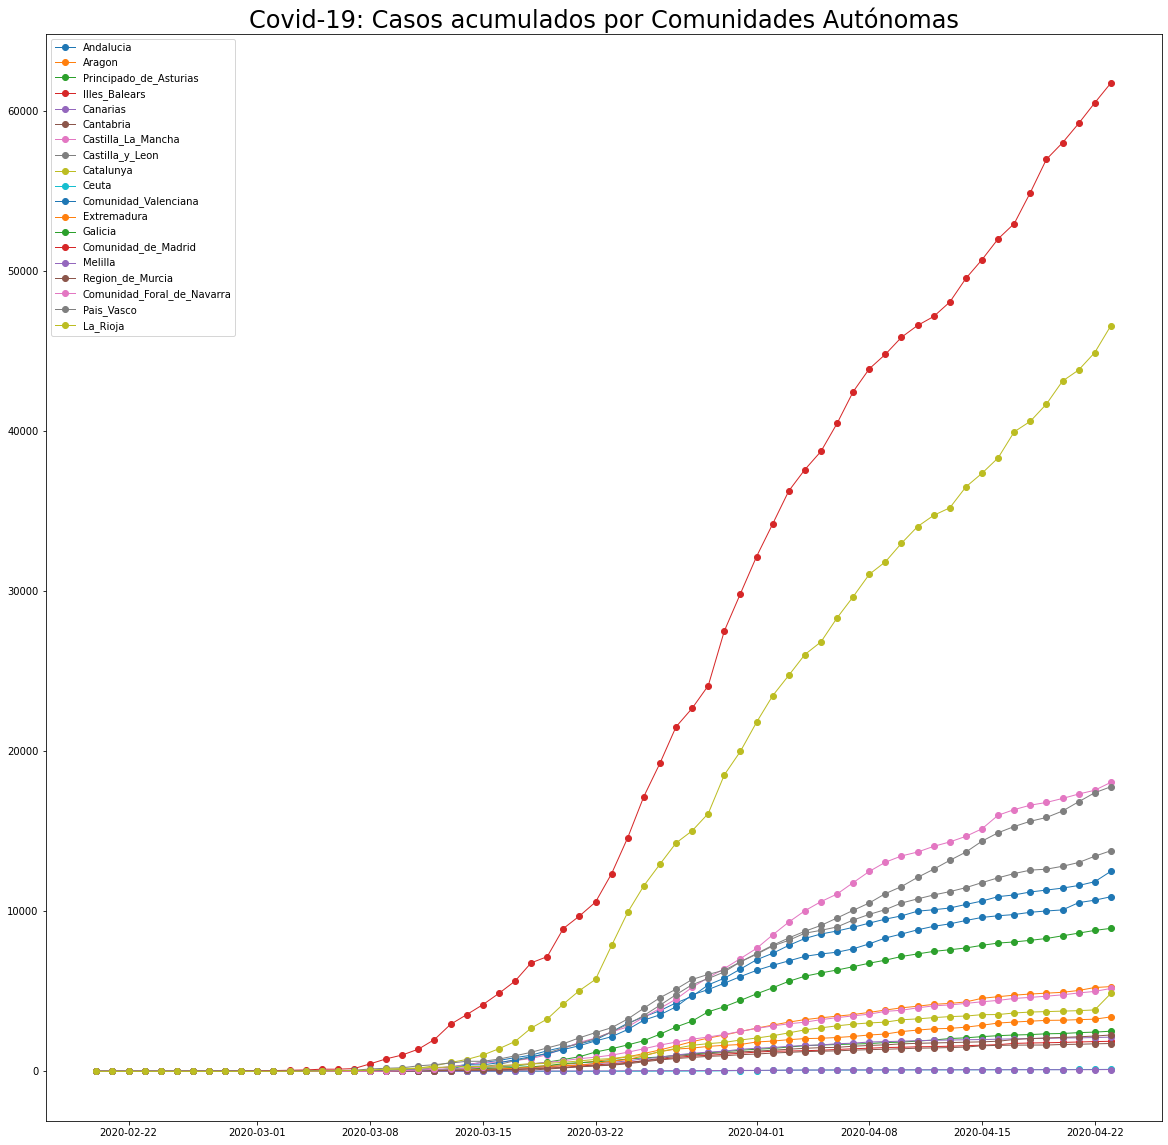

In [78]:
fig = plt.figure(figsize=(20,20))
ccaa_list = list(df_input['ccaa_name'].unique())
for v in ccaa_list:
    tmp = df_input[df_input['ccaa_name']==v]
    plt.plot(tmp['fecha'], tmp['casos'].astype(int), marker='o', ls='-', lw=1, label=v)
plt.title('Covid-19: Casos acumulados por Comunidades Autónomas', fontsize=24)
plt.legend()
plt.show()

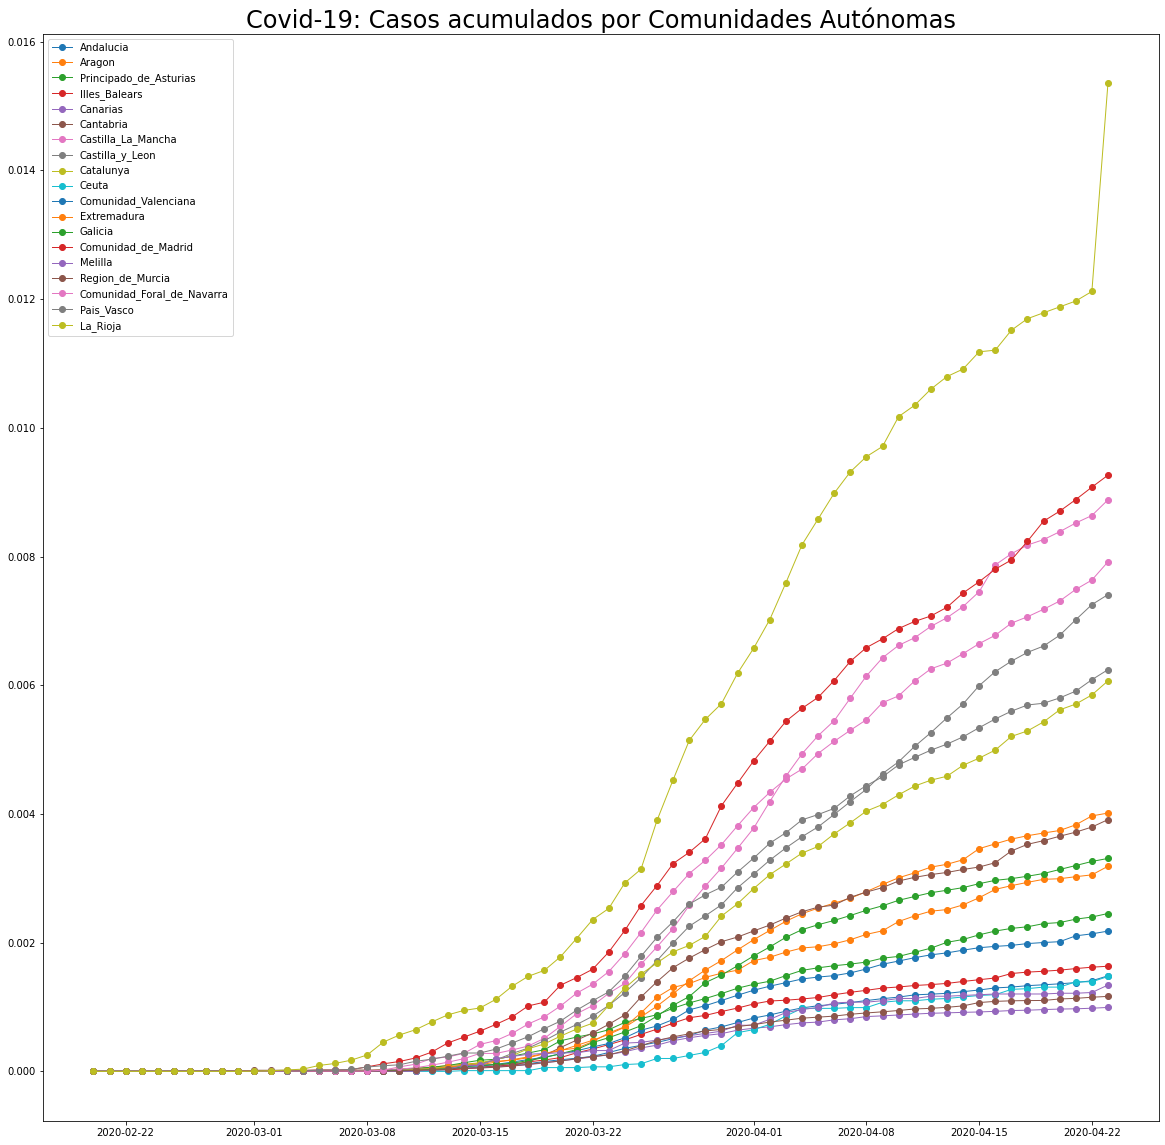

In [76]:
fig = plt.figure(figsize=(20,20))
ccaa_list = list(df_input['ccaa_name'].unique())
for v in ccaa_list:
    tmp = df_input[df_input['ccaa_name']==v]
    plt.plot(tmp['fecha'], tmp['casos']/float(df_pop[df_pop['ccaa_name']==v]['population']), marker='o', ls='-', lw=1, label=v)
plt.title('Covid-19: Casos acumulados por Comunidades Autónomas', fontsize=24)
plt.legend()
plt.show()

## Split data into: train and test

In [81]:
df_input.index = df_input['fecha']
df_train = df_input.loc['2020-03-16':'2020-04-18'][['ccaa_name','casos']]
print(df_train.tail())
df_test = df_input.loc['2020-04-19':][['ccaa_name','casos']]
print(df_test.tail())

                             ccaa_name    casos
fecha                                          
2020-04-18                     Melilla    104.0
2020-04-18            Region_de_Murcia   1644.0
2020-04-18  Comunidad_Foral_de_Navarra   4621.0
2020-04-18                  Pais_Vasco  12569.0
2020-04-18                    La_Rioja   3705.0
                             ccaa_name    casos
fecha                                          
2020-04-23                     Melilla    116.0
2020-04-23            Region_de_Murcia   1741.0
2020-04-23  Comunidad_Foral_de_Navarra   5180.0
2020-04-23                  Pais_Vasco  13780.0
2020-04-23                    La_Rioja   4865.0


0       0.000000
19      0.000000
38      0.000000
57      0.000000
76      0.000000
          ...   
1121    0.001346
1140    0.001360
1159    0.001380
1178    0.001408
1197    0.001485
Name: casos, Length: 64, dtype: float64

In [71]:
v

'Andalucia'

In [72]:
ccaa_list

['Andalucia',
 'Aragon',
 'Principado_de_Asturias',
 'Illes_Balears',
 'Canarias',
 'Cantabria',
 'Castilla_La_Mancha',
 'Castilla_y_Leon',
 'Catalunya',
 'Ceuta',
 'Comunidad_Valenciana',
 'Extremadura',
 'Galicia',
 'Comunidad_de_Madrid',
 'Melilla',
 'Region_de_Murcia',
 'Comunidad_Foral_de_Navarra',
 'Pais_Vasco',
 'La_Rioja']